<a href="https://colab.research.google.com/github/tafartech/Vision-captioner/blob/main/Vision_Captioner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
!pip install -U -q keras keras-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 107.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompati

# Set Kaggle Auth

In [2]:
import os
from google.colab import userdata

# Kaggle auth.
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

*Now let's import Keras -- we'll use the JAX backend, but Keras & PaliGemma also work with PyTorch and TensorFlow*

In [3]:
# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"

In [4]:
# Import Keras & KerasNLP
import keras
import keras_nlp

# Import other useful tools
from matplotlib import pyplot as plt
import numpy as np

In [5]:
# Make sure we run in bfloat16, to save memory and compute
keras.config.set_floatx("bfloat16")

**Next, let's grab the model from Kaggle. Multiple versions are available, in particular different version targeting images in 224x224 resolution, 448x448, and 896x896. We'll use the larger one.**

In [6]:
# Load up the pretrained PaliGemma 3B model for 896x896 img inputs
pali_gemma_lm = keras_nlp.models.PaliGemmaCausalLM.from_preset(
    "pali_gemma_3b_896"
)
# pali_gemma_lm.summary()

100%|██████████| 861/861 [00:00<00:00, 776kB/s]
100%|██████████| 5.45G/5.45G [01:51<00:00, 52.7MB/s]
100%|██████████| 410/410 [00:00<00:00, 289kB/s]
100%|██████████| 4.07M/4.07M [00:00<00:00, 9.43MB/s]


Finally, let's define a couple of useful utilities. This version of PaliGemma takes images that are 896x896, so we'll need to resize our images to that format using `keras.ops.image.resize`. To avoid aspect ratio distortion, we'll pad non-square images using `pad_to_aspect_ratio=True`. You could also pass `crop_to_aspect_ratio=True` to crop instead of padding.

In [7]:
image_size = (896, 896)

def resize_and_pad(x):
    return keras.ops.image.resize(x, image_size, pad_to_aspect_ratio=True)

def prepare_image(url):
    path = keras.utils.get_file(origin=url)
    image = keras.utils.load_img(path)
    return resize_and_pad(keras.utils.img_to_array(image))

*Let's start with a test image with some orange tulips. Can PaliGemma tell what's in the image?*

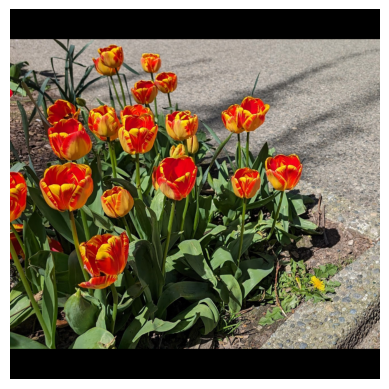

In [8]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import tensorflow as tf
from tensorflow import keras

image_size = (896, 896)

def resize_and_pad(x):
    return keras.ops.image.resize(x, image_size, pad_to_aspect_ratio=True)

def download_and_prepare_image(image_url):
    """
    Downloads and preprocesses an image from a given URL.

    Parameters:
    - image_url: URL of the image to download and preprocess.

    Returns:
    - image: Preprocessed image ready for model input.
    """
    try:
        response = requests.get(image_url, timeout=10)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        image = keras.utils.img_to_array(image)
        image = resize_and_pad(image)
        return image
    except Exception as e:
        print(f"Error downloading and preparing image: {e}")
        return None  # Return None on error


# Main execution
if __name__ == "__main__":
    IMAGE_URL = "https://s3.amazonaws.com/keras.io/img/book/flowers.jpg"
    image = download_and_prepare_image(IMAGE_URL)

    if image is not None:  # Check if image preparation was successful
        plt.imshow(keras.ops.convert_to_numpy(image).astype("uint8"))
        plt.axis("off")
        plt.show()

In [13]:
outputs = pali_gemma_lm.generate(
    inputs={
        "images": keras.ops.expand_dims(image, axis=0),
        "prompts": ['describe en\n',],
    }
)
print(outputs[0])

describe en
Tulips in the park


# Generate caption for image with PaliGemma

In [14]:
def generate_caption(pali_gemma_lm, image, prompt="What color are the flowers?\n"):
    """Generates a caption (answer to a question) for an image using the PaliGemma model.

    Args:
        pali_gemma_lm: The loaded PaliGemma language model.
        image: The preprocessed image (NumPy array).
        prompt (str, optional): The question to ask the model (default: "What color are the flowers?").

    Returns:
        str: The model's answer to the prompt.
    """

    try:
        # Generate the answer
        outputs = pali_gemma_lm.generate(  # Use pali_gemma_lm for generation
            inputs={
                "images": keras.ops.expand_dims(image, axis=0),
                "prompts": [prompt],  # Use the provided prompt
            }
        )

        # Extract the answer
        answer = outputs[0]

        return answer

    except Exception as e:
        print(f"Error generating answer: {e}")
        return "Error: Could not generate an answer."

In [16]:
# Example with the default prompt
answer = generate_caption(pali_gemma_lm, image)
print(f"Answer: {answer}")

# Example with a custom prompt
custom_prompt = "How many flowers are in the image?\n"
answer = generate_caption(pali_gemma_lm, image, custom_prompt)
print(f"Answer: {answer}")

Answer: What color are the flowers?
red and yellow
Answer: How many flowers are in the image?
2


# Test PaliGemma image captioning with another image.

Code with a New Image URL:

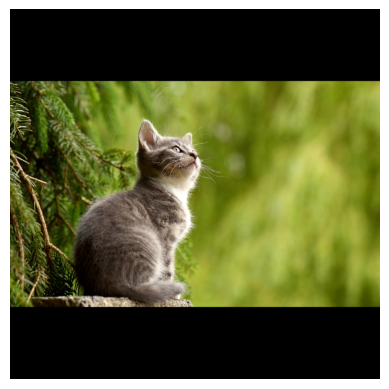

Answer: What color is the cat?
gray
Answer: What animal is in the picture?
kitten
Answer: Where is the cat?
in tree


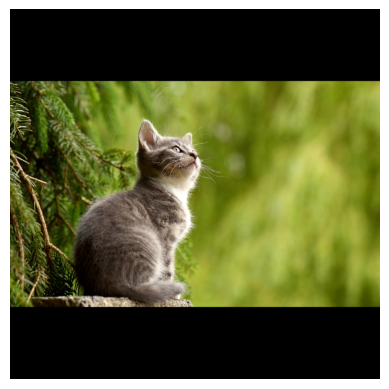

In [18]:

# Main execution
if __name__ == "__main__":
    IMAGE_URL = "https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492_1280.jpg"

    image = download_and_prepare_image(IMAGE_URL)

    if image is not None:  # Check if image preparation was successful
        plt.imshow(keras.ops.convert_to_numpy(image).astype("uint8"))
        plt.axis("off")
        plt.show()
# process

    if image is not None:
        # Example 1: What color?
        answer1 = generate_caption(pali_gemma_lm, image, "What color is the cat?\n")
        print(f"Answer: {answer1}")

        # Example 2: What animal?
        answer2 = generate_caption(pali_gemma_lm, image, "What animal is in the picture?\n")
        print(f"Answer: {answer2}")

        # Example 3: Where is the cat?
        answer3 = generate_caption(pali_gemma_lm, image, "Where is the cat?\n")
        print(f"Answer: {answer3}")

        # (Optionally) Display the image
        plt.imshow(keras.ops.convert_to_numpy(image).astype("uint8"))
        plt.axis("off")
        plt.show()

# Object detection
You can also use PaliGemma to perform object detection and image segmentation. The commands to use are:

* `"detect {class}\n"`
* `"segment {class}\n"`

Let's try it on an image of a train:

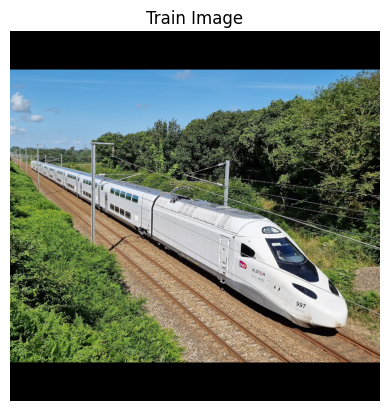

In [29]:
# Main execution
if __name__ == "__main__":
    # Image URL of a train (no API key needed)
    TRAIN_IMAGE_URL = "https://s3.amazonaws.com/keras.io/img/book/tgv.jpg"

    image = download_and_prepare_image(TRAIN_IMAGE_URL)

    if image is not None:
        # Display the image BEFORE caption generation
        plt.imshow(keras.ops.convert_to_numpy(image).astype("uint8"))
        plt.axis("off")
        plt.title("Train Image")
        plt.show()

In [32]:
def detect_object(pali_gemma_lm, image, object_class="train"):
    """Detects objects in an image.

    Args:
        pali_gemma_lm: The loaded PaliGemma language model.
        image: The preprocessed image (NumPy array).
        object_class (str, optional): The object class to detect (default: "train").

    Returns:
        str: The detection result.
    """

    try:
        output = pali_gemma_lm.generate(
            inputs={"images": keras.ops.expand_dims(image, axis=0), "prompts": [f"detect {object_class}\n"]}
        )[0]  # Directly access the first (and only) output element
        return output
    except Exception as e:
        print(f"Error detecting object: {e}")
        return "Error: Could not detect object."

In [31]:
# Check the print results

result = detect_object(pali_gemma_lm, image)
print(result)

detect train
<loc0355><loc0059><loc0824><loc0930> train


*The first part of the output is the detection bounding box, and the second part is the class name -- "train". Let's plot the detection bounding over the image*

detect train
<loc0355><loc0059><loc0824><loc0930> train


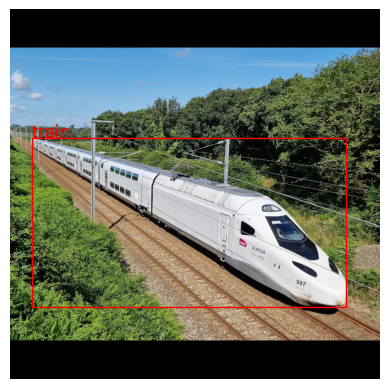

In [40]:
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
import tensorflow as tf
from tensorflow import keras
import re
import numpy as np

image_size = (896, 896)

def resize_and_pad(x):
    return keras.ops.image.resize(x, image_size, pad_to_aspect_ratio=True)

def download_and_prepare_image(image_url):
    """Downloads and preprocesses an image from a URL."""
    try:
        response = requests.get(image_url, timeout=10)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        image = keras.utils.img_to_array(image)
        image = resize_and_pad(image)
        return image
    except Exception as e:
        print(f"Error downloading and preparing image: {e}")
        return None

def detect_object(pali_gemma_lm, image, object_class="train"):
    """Detects objects in an image using PaliGemma."""
    try:
        output = pali_gemma_lm.generate(
            inputs={"images": keras.ops.expand_dims(image, axis=0), "prompts": [f"detect {object_class}\n"]}
        )[0]
        return output
    except Exception as e:
        print(f"Error detecting object: {e}")
        return "Error: Could not detect object."

def parse_bbox_and_labels(detokenized_output):
  matches = re.finditer(
      '<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>'
      ' (?P<label>.+?)( ;|$)',
      detokenized_output,
  )
  labels, boxes = [], []
  fmt = lambda x: float(x) / 1024.0
  for m in matches:
    d = m.groupdict()
    boxes.append([fmt(d['y0']), fmt(d['x0']), fmt(d['y1']), fmt(d['x1'])])
    labels.append(d['label'])
  return np.array(boxes), np.array(labels)

def display_boxes(image, boxes, labels):
  h, l = image.shape[0], image.shape[1]
  fig, ax = plt.subplots()
  ax.imshow(keras.ops.convert_to_numpy(image).astype("uint8"))
  ax.axis("off")
  for i in range(boxes.shape[0]):
      y, x, y2, x2 = (boxes[i]*h)
      width = x2 - x
      height = y2 - y
      rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
      plt.text(x, y, labels[i], color='red', fontsize=12)
      ax.add_patch(rect)

  plt.show()


# Main execution
if __name__ == "__main__":
    # ... (Your code to load the PaliGemma model) ...

    # Image URL of a train (no API key needed)
    #TRAIN_IMAGE_URL = "Your train image URL here"
    # Assuming you have your image path
    image = download_and_prepare_image(TRAIN_IMAGE_URL)

    if image is not None:
        result = detect_object(pali_gemma_lm, image)
        print(result)

        boxes, labels = parse_bbox_and_labels(result)
        if boxes is not None and labels is not None and boxes.size > 0 and labels.size > 0:
            display_boxes(image, boxes, labels)
        else:
            print("No objects detected.")

*The image demonstrates that the PaliGemma model successfully detected the train in the picture. The red bounding box accurately encompasses the entire train, indicating the model's ability to precisely locate the object within the frame. The label `"train"` correctly identifies the object.
This result suggests that the model is proficient in object detection.*

# OCR
Finally, PaliGemma can also perform OCR.

289076/289076 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


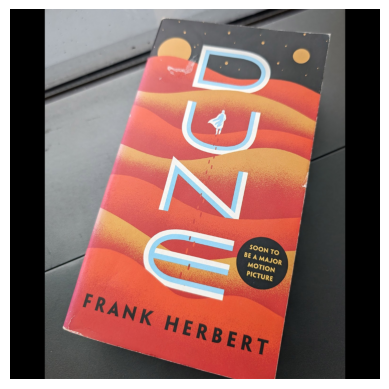

In [43]:
image = prepare_image("https://s3.amazonaws.com/keras.io/img/book/dune.jpg")
plt.imshow(keras.ops.convert_to_numpy(image).astype("uint8"))
plt.axis("off")
plt.show()

In [46]:
if image is not None:  # Check if 'image' variable exists and is valid
    result = perform_ocr(pali_gemma_lm, image)
    print(result)

    boxes, labels = parse_bbox_and_labels(result)
    if boxes is not None and labels is not None and boxes.size > 0 and labels.size > 0:
        display_boxes_and_text(image, boxes, labels)

ocr
dune
soon to be a major motion picture
frank herbert
